In [1]:
import sys
sys.path.append('..')
from lib.download import *
from tqdm import tqdm
import numpy as np

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By

import concurrent.futures
import queue

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

C:\Users\remik\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#### DRIVER ####

def get_driver():
    options = Options()
    options.binary_location = r"C:\Program Files\Mozilla Firefox\firefox.exe"
    capabilities = DesiredCapabilities().FIREFOX
    capabilities["marionette"] = False
    capabilities["firefoxOptions"] = {"args": ["--headless"]}
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
    }
    for header, value in headers.items():
        options.set_preference(f"general.useragent.override", headers["User-Agent"])
    driver = webdriver.Firefox(options=options)
    return driver

#### HREFS ####

def get_page_hrefs(page_number, driver, ticker):
    url = f"https://www.tradingview.com/symbols/{ticker}/ideas/page-{page_number}/?sort=recent"
    driver.get(url)
    hrefs = [hrf.get_attribute("href") for hrf in driver.find_elements(By.CLASS_NAME, 'tv-widget-idea__title')]
    return hrefs

def worker(url_queue, result_queue, driver, ticker):
    while not url_queue.empty():
        page_number = url_queue.get()
        hrefs = get_page_hrefs(page_number, driver, ticker)
        result_queue.put(hrefs)        
        
def get_all_pages_hrefs(max_workers=6, start_page=2, end_page=500, ticker='BTCUSDT'):
    hrefs = []
    url_queue = queue.Queue()
    result_queue = queue.Queue()

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        drivers = [get_driver() for i in range(max_workers)]
        for page_number in range(start_page, end_page):
            url_queue.put(page_number)

        future_to_worker = [executor.submit(worker, url_queue, result_queue, drivers[i], ticker) for i in range(max_workers)]

        concurrent.futures.wait(future_to_worker)

    while not result_queue.empty():
        hrefs.extend(result_queue.get())

    for driver in drivers:
        driver.quit()

    return hrefs

#### IDEAS ####

def worker_ideas(href_queue, result_queue, driver):
    while not href_queue.empty():
        href = href_queue.get()
        driver.get(href)
        user = driver.find_element(By.CLASS_NAME, "tv-chart-view__title-user-name").text
        time = driver.find_element(By.CLASS_NAME, "tv-chart-view__title-time").get_attribute('title')
        title = driver.find_element(By.CLASS_NAME, 'tv-chart-view__title-name').text
        content = driver.find_element(By.CLASS_NAME, 'tv-chart-view__description').text.replace('\n','')
        result_queue.put((time, title, user, content))   

def get_data_from_hrefs(hrefs, max_workers=6):
    result_queue = queue.Queue()
    href_queue = queue.Queue()
    for href in hrefs:
        href_queue.put(href)

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        drivers = [get_driver() for i in range(max_workers)]
        future_to_worker = [executor.submit(worker_ideas, href_queue, result_queue, drivers[i]) for i in range(max_workers)]
        concurrent.futures.wait(future_to_worker)

    times, titles, contents, users = [], [], [], []
    while not result_queue.empty():
        time, title, user, content = result_queue.get()
        corresps = [[times,time],[contents,content],[titles,title],[users,user]]  
        for corresp in corresps:
            corresp[0].append(corresp[1]) 
    
    for driver in drivers:
        driver.quit()

    data = pd.DataFrame({'time': times, 'title': titles, 'user': users, 'article': contents})
    data[["pos", "neg", "neut"]] = np.nan
    
    return data


#### NEWS ####

def ticker_news_dataset(ticker):
    driver = get_driver()
    url = f"https://www.tradingview.com/symbols/{ticker}/news/?sort=recent"
    driver.get(url)
    times, titles, contents, sources = [], [], [], [] 
    hrefs =[hrf.get_attribute("href") for hrf in driver.find_elements(By.CLASS_NAME, 'card-gaCYEutU')] 
    for href in tqdm(hrefs): 
        driver.get(href)
        source = driver.find_elements(By.CLASS_NAME,"logoLight-cR1GoJcP")[0].get_attribute("alt")
        time = driver.find_elements(By.CSS_SELECTOR,"time[datetime]")[0].text
        title = driver.find_elements(By.CLASS_NAME, 'title-jEK_kEtx')[0].text
        content = [text.text for text in driver.find_elements(By.CSS_SELECTOR, "div.body-jEK_kEtx.body-op4L5uvo.content-op4L5uvo span p")]
        corresps = [[times,time],[contents,content],[titles,title],[sources,source]]  
        for corresp in corresps:
            corresp[0].append(corresp[1])
    contents = [' '.join(content) for content in contents]
    data = pd.DataFrame({'time' : times, 'title' : titles, 'source' : sources, 'article' : contents})
    data['time'] = pd.to_datetime(data['time'], format="%b %d, %Y%H:%M") + pd.Timedelta(hours=1)
    data['time'] = data['time'].dt.strftime('%Y-%m-%d %H:%M')
    data[["pos","neg","neut"]] = np.nan
    return data

#### FinBERT ####

def chunk_weights(chunk_len):
    return [512] * (chunk_len // 512) + [chunk_len % 512] if chunk_len else []

def article_sentiment(df, article_index):
    txt = df['article'][article_index]
    window_size = 510
    tokens = tokenizer.encode_plus(txt, add_special_tokens=False)
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    total_len = len(input_ids)
    
    probs_list = []
    for start in range(0, total_len, window_size):
        end = min(start + window_size, total_len)
        input_ids_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]
        input_ids_chunk = [101] + input_ids_chunk + [102]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]
        padding = [0] * (window_size - len(input_ids_chunk) + 2)
        input_ids_chunk += padding
        attention_mask_chunk += padding
        input_dict = {
            'input_ids': torch.LongTensor([input_ids_chunk]),
            'attention_mask': torch.IntTensor([attention_mask_chunk])
        }
        outputs = model(**input_dict)
        probs = torch.nn.functional.softmax(outputs[0], dim=-1)
        probs_list.append(probs)

    cw = chunk_weights(total_len)
    weights = [x/total_len for x in cw]
    weighted_probs = torch.FloatTensor(probs_list[0].shape)
    for chunk, weight in zip(probs_list, weights):
        weighted_probs += chunk * weight
    weighted_probs = weighted_probs.detach().cpu().numpy()[0] 
    df['pos'].iloc[article_index] = weighted_probs[0]
    df['neg'].iloc[article_index] = weighted_probs[1]
    df['neut'].iloc[article_index] = weighted_probs[2]
    return df

In [11]:
#hrefs = get_all_pages_hrefs()
#pd.DataFrame(hrefs).to_csv('hrfs.csv')

In [19]:
hrefs = pd.read_csv('hrfs.csv').iloc[:,-1:]
hrefs = [href[0] for href in hrefs.values.tolist()]

In [20]:
#data = get_data_from_hrefs(hrefs)
#data.to_csv('btcinfos.csv'

In [5]:
data = pd.read_csv('btcinfos.csv').iloc[:,1:]

<AxesSubplot:>

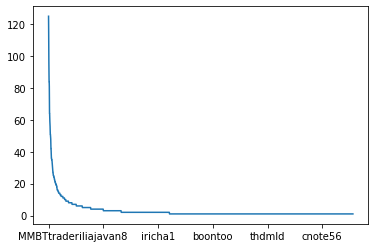

In [10]:
data['user'].value_counts().plot()

In [29]:
len(data)

8962

In [13]:
from tqdm import tqdm
for i in tqdm(range(0,len(data))):
    try:
        data = article_sentiment(data,i)   
    except:
        None

100%|██████████| 8962/8962 [3:36:31<00:00,  1.45s/it]  


In [14]:
data.tail()

,time,title,user,article,pos,neg,neut
8957,NaN,btc usdt,BullsFinance,"looking for this zone for a long setup, i thin...",0.236987,0.016421,0.746593
8958,"18:29 - Oct 7, 2022",btcusdt 4h uptade,Crypto_Players,BTC /USDT :- 4h 🕘Update ::Btc currently trade ...,0.335169,0.099860,0.564970
8959,"18:20 - Oct 7, 2022",12K FOR BITCOIN? VERY MUCH LIKELY.,patlaka2000,We are moving through thin air. It is a matter...,0.036937,0.104326,0.858737
8960,"17:57 - Oct 7, 2022",BTCUSDT Down Trend.!,TRADiNG_Club_,#BTCUSDT Looking for Sell trade setup as I men...,0.108842,0.017997,0.873161
8961,"18:07 - Oct 7, 2022",BTC,PUMPmaps,The price fell to the ascending trend line aft...,0.104066,0.784580,0.111354


In [ ]:
# Calculating the hourly average sentiment score
def get_daily_average_sentiment_score(df):
    return df.groupby("date")["sentiment_score"].mean()

In [ ]:
output => sentiment moyen par journal + poids  + changer usd/eur + vader (twitter reddit ideas)

In [ ]:
essayer avec btcusd aussi, essayer avec ideas, essayer de pondérer par paragraphe (pour eviter biais des sentiumlents qui peuvnt changer en fonction de la ccl)

In [ ]:
historical features